In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
""" Note that you need to alter tmin to -1, tmax to 5, and baseline to (None, 1) for this plot to correctl visualize -1 to 5 seconds """

' Note that you need to alter tmin to -1, tmax to 5, and baseline to (None, 1) for this plot to correctl visualize -1 to 5 seconds '

CONSTANTS

In [3]:
from helpers import extract_eeg, preprocess, prepare_data, run_model, evaluate_model, compute_empirical_chance
from pathlib import Path
import os
import matplotlib.pyplot as plt

In [4]:
MODEL = 'lda'                       # classifier ('svm', 'rf', 'lda', 'xgb')
PCA, N_COMPONENTS = True, 20        # PCA downsampling
TIME_DOWNSAMPLE_FACTOR = 4          # Time downsampling factor
N_FOLDS = 4                         # num. folds for K_folds

In [34]:
import numpy as np
import mne

channel = 'Cz'
window_size = 50  # Num samples in moving average window

def moving_average(signal, window_size):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='valid')

def compute_grand_average_with_error(epochs, channel, window_size):
    data = epochs.get_data(picks=channel)  # Shape: (n_epochs, n_times)
    smoothed_signals = []

    for epoch_signal in data:  # Each epoch_signal is a 1D array (n_times,)
        smoothed_signal = moving_average(epoch_signal.flatten(), window_size)
        smoothed_signals.append(smoothed_signal)
    
    smoothed_signals = np.array(smoothed_signals)  # Shape: (n_epochs, n_times after smoothing)
    grand_averaged_signal = np.mean(smoothed_signals, axis=0)
    standard_error = np.std(smoothed_signals, axis=0) / np.sqrt(smoothed_signals.shape[0])  # SEM
    return grand_averaged_signal, standard_error

def plot_CNV(go_epochs, nogo_epochs):
    # Compute grand averages for each condition
    go_grand_avg, go_std_error = compute_grand_average_with_error(go_epochs, channel, window_size)
    nogo_grand_avg, nogo_std_error = compute_grand_average_with_error(nogo_epochs, channel, window_size)

    # Time axis (adjusted for your -1 to 5 seconds range)
    sampling_rate = go_epochs.info['sfreq']
    time_points = np.linspace(-1, 5, len(go_grand_avg))  # Match the length of averaged signals

    # Plot
    plt.figure(figsize=(10, 6))

    # Plot go condition
    plt.plot(time_points, go_grand_avg, label='Go', color='blue')
    plt.fill_between(time_points, go_grand_avg - go_std_error, go_grand_avg + go_std_error, 
                    color='blue', alpha=0.2)

    # Plot nogo condition
    plt.plot(time_points, nogo_grand_avg, label='NoGo', color='red')
    plt.fill_between(time_points, nogo_grand_avg - nogo_std_error, nogo_grand_avg + nogo_std_error, 
                    color='red', alpha=0.2)

    # Add vertical lines for S1 and S2
    plt.axvline(x=0, color='black', linestyle='--', label='S1 (0 s)')
    plt.axvline(x=4.3, color='black', linestyle='--', label='S2 (4.3 s)')

    # Labels and legend
    plt.title(f'Grand Averaged Signals with Std Error for {channel}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()


EXTRACT EEG

In [35]:
# Data Split A
train_pth_A = Path(r"data/train_A")                    # ses1 
test_pth_A_s2 = Path(r"data/test_A_ses2")              # ses2
test_pth_A_s3 = Path(r"data/test_A_ses3")              # ses3

# train data load (use .fif if exists else create new)
all_go_epochs_train_A, all_nogo_epochs_train_A = extract_eeg(folder_name=train_pth_A, fif_name=Path(r"loaded_data/train_A.fif"))
all_go_epochs_test_A_s2, all_nogo_epochs_test_A_s2 = extract_eeg(folder_name=test_pth_A_s2, fif_name=Path(r"loaded_data/test_A_s2.fif"))
all_go_epochs_test_A_s3, all_nogo_epochs_test_A_s3 = extract_eeg(folder_name=test_pth_A_s3, fif_name=Path(r"loaded_data/test_A_s3.fif"))

File loaded_data\train_A.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\train_A.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\train_A.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_A_s2.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_A_s2.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_A_s2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
File loaded_data\test_A_s3.fif already exists. Loading data.
Reading c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\loaded_data\test_A_s3.fif ...
    Found the data of interest:
        t =   -1000.00 ...    5000.00 ms
        0 CTF compensation matrices available


c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:52: RuntimeWarning: This filename (loaded_data\test_A_s3.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fif_name, preload=True)


Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated


Not setting metadata
336 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
336 matching events found
Applying baseline correction (mode: mean)


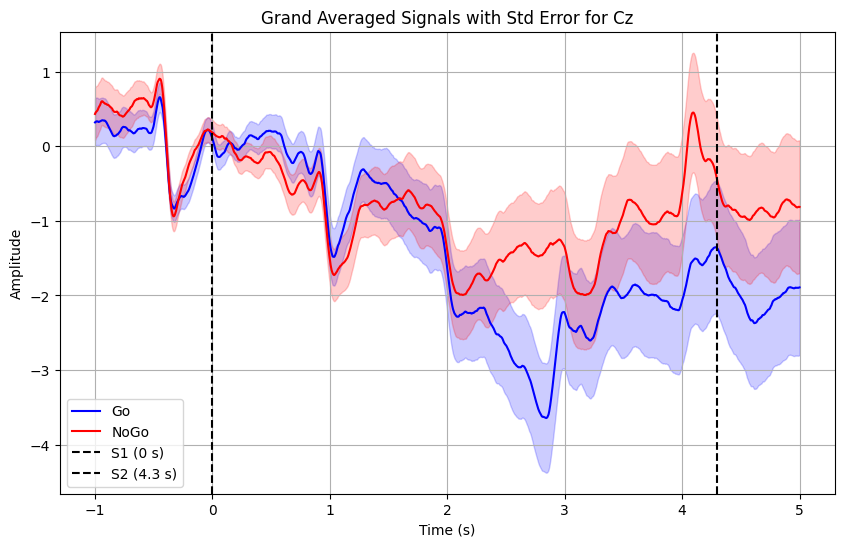

In [36]:
# Combine multiple go and nogo epoch objects
all_go_epochs = [all_go_epochs_train_A, all_go_epochs_test_A_s2, all_go_epochs_test_A_s3]  # Replace with your go epoch objects
all_nogo_epochs = [all_nogo_epochs_train_A, all_nogo_epochs_test_A_s2, all_nogo_epochs_test_A_s3]        # Replace with your nogo epoch objects

# Load go and nogo epochs (assuming you already have them as mne.Epochs objects)
go_epochs = mne.concatenate_epochs(all_go_epochs)
nogo_epochs = mne.concatenate_epochs(all_nogo_epochs)

plot_CNV(go_epochs, nogo_epochs)

PREPROCESS

In [37]:
all_go_epochs_train_A, all_nogo_epochs_train_A = preprocess(all_go_epochs_train_A, all_nogo_epochs_train_A)
all_go_epochs_test_A_s2, all_nogo_epochs_test_A_s2 = preprocess(all_go_epochs_test_A_s2, all_nogo_epochs_test_A_s2)
all_go_epochs_test_A_s3, all_nogo_epochs_test_A_s3 = preprocess(all_go_epochs_test_A_s3, all_nogo_epochs_test_A_s3)

Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    2.1s
[Pa

Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    2.1s
[

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    2.0s
[Pa

Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    2.3s
[

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (

c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:238: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_go_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.7s
[Pa

Setting up band-pass filter from 0.1 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 16897 samples (33.002 s)



c:\Users\ranit\Neural_Projects\VR-BCI-Cognitive-Training\helpers.py:239: RuntimeWarning: filter_length (16897) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  all_nogo_epochs.filter(l_freq=0.1, h_freq=1)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.8s
[

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


Not setting metadata
336 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
Not setting metadata
336 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)


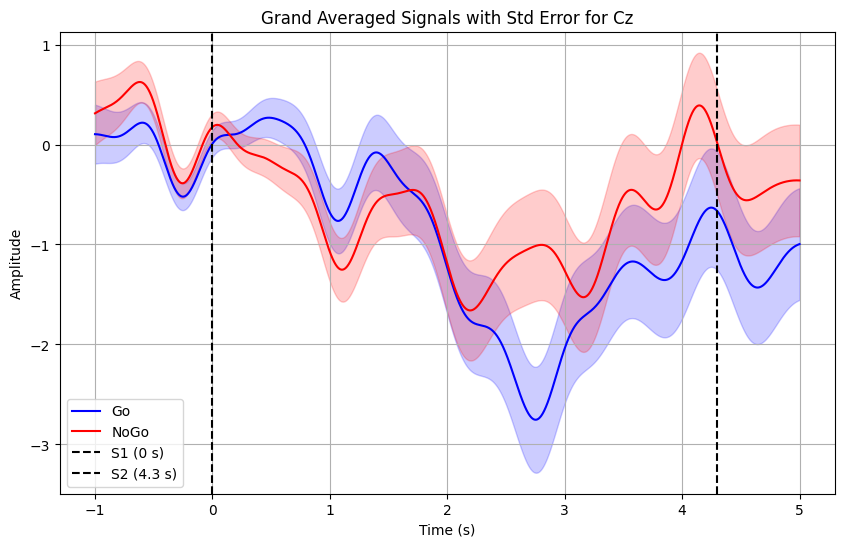

In [38]:
# Combine multiple go and nogo epoch objects
all_go_epochs = [all_go_epochs_train_A, all_go_epochs_test_A_s2, all_go_epochs_test_A_s3]  # Replace with your go epoch objects
all_nogo_epochs = [all_nogo_epochs_train_A, all_nogo_epochs_test_A_s2, all_nogo_epochs_test_A_s3]        # Replace with your nogo epoch objects

# Load go and nogo epochs (assuming you already have them as mne.Epochs objects)
go_epochs = mne.concatenate_epochs(all_go_epochs)
nogo_epochs = mne.concatenate_epochs(all_nogo_epochs)

plot_CNV(go_epochs, nogo_epochs)

In [48]:
def window_average(epochs, window_size):

    # get raw data (shape: n_epochs, n_channels, n_times)
    data = epochs.get_data()
    n_epochs, n_channels, n_times = data.shape

    crop_start = 0 # to start at 2.3 s (orig at 1-4.3s, so 1.3s * 512 ~ 666)
    smoothed_data = np.zeros((n_epochs, n_channels, n_times - crop_start - window_size + 1))
    
    # Apply moving average per epoch, channel
    for i_epoch in range(n_epochs):
        for i_channel in range(n_channels):
            signal = data[i_epoch, i_channel, crop_start:n_times] # extract 2.3 to 4.3 period
            smoothed_data[i_epoch, i_channel] = moving_average(signal, window_size)
    
    # make new epoch object
    info = epochs.info
    times = epochs.times[:smoothed_data.shape[2]]  # Adjust time array for new length
    updated_epochs = mne.EpochsArray(smoothed_data, info, tmin=times[0])

    return updated_epochs

In [45]:
import mne
from mne.viz import plot_topomap

def plot_cnv_topoplots(go_epochs, nogo_epochs):
    # Compute grand averages for each condition
    go_epochs_avgd = window_average(go_epochs, window_size)
    nogo_epochs_avgd = window_average(nogo_epochs, window_size)

    # Define time points
    time_points = [0, 2.3, 2.74, 4.3]
    time_indices = [np.argmin(np.abs(go_epochs_avgd.times - t)) for t in time_points]

    # create figure
    fig, axes = plt.subplots(2, 4, figsize=(16, 6), constrained_layout=True)
    fig.suptitle("Go and No-Go at Different Time Points", fontsize=16)
    for i, t_idx in enumerate(time_indices):

        # Get data for topomap plotting
        go_data = go_epochs_avgd.get_data()[:, 0:32, t_idx].mean(axis=0)  # Average across epochs
        nogo_data = nogo_epochs_avgd.get_data()[:, 0:32, t_idx].mean(axis=0)

        im, _ = plot_topomap(
            go_data,  # Data at the specific time index
            go_epochs_avgd.info,
            axes=axes[0, i],
            show=False
        )
        axes[0, i].set_title(f"{time_points[i]}s (Go)", fontsize=10)

        im, _ = plot_topomap(
            nogo_data,  # Data at the specific time index
            nogo_epochs_avgd.info,
            axes=axes[1, i],
            show=False
        )
        axes[1, i].set_title(f"{time_points[i]}s (No-Go)", fontsize=10)

    plt.show()

C:\Users\ranit\AppData\Local\Temp\ipykernel_149148\1855017594.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
336 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_149148\1855017594.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Not setting metadata
336 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\ranit\AppData\Local\Temp\ipykernel_149148\183561864.py:19: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  go_data = go_epochs_avgd.get_data()[:, 0:32, t_idx].mean(axis=0)  # Average across epochs
C:\Users\ranit\AppData\Local\Temp\ipykernel_149148\183561864.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  nogo_data = nogo_epochs_avgd.get_data()[:, 0:32, t_idx].mean(axis=0)
C:\Users\ranit\AppData\Local\Temp\ipykernel_149148\183561864.py:19: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  go_data = go_epochs_avgd.get_data()[:, 0:32, t_idx].mean(axis=0)  # Average across epochs
C:\Users\ranit\AppData\Local\Temp\ipykernel_149148\183561864.py:20: FutureWarning: The current default of copy=False will change t

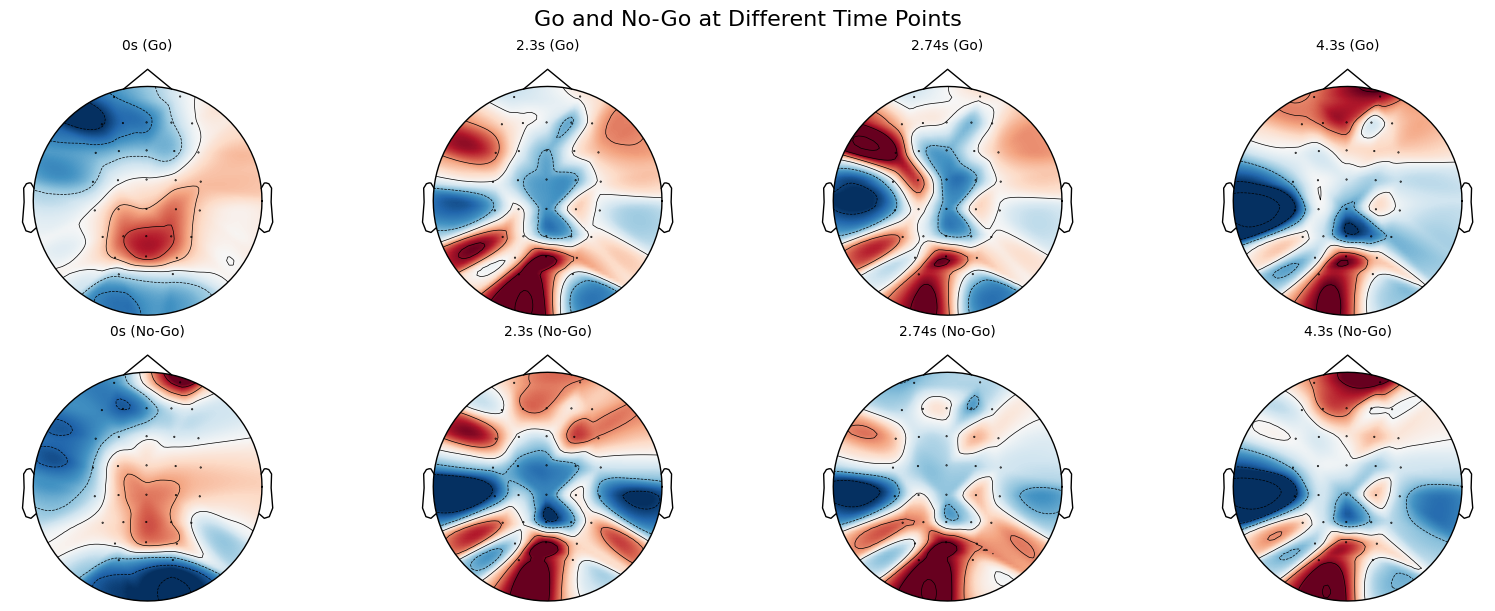

In [46]:
plot_cnv_topoplots(go_epochs, nogo_epochs)